In [1]:
from __future__ import print_function

import math
import pickle

import pandas as pd
import numpy as np
import numpy.random
import scipy.sparse as sp
import sklearn.preprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torch.nn
import torch.optim

In [2]:
# df_gender = 
df_gender = pd.get_dummies(df_gender[['user_id', 'gender']], columns=['gender'])
df_gender.columns = ['user_id', 'female', 'male']
df_gender.head()

,user_id,female,male
0,128355,0,1
1,679726,0,1
2,1035652,1,0
3,264047,0,1
4,561368,0,1


In [3]:
# df_article = 
df_article = df_article[['article_id', 'category']]
df_article.head()

,article_id,category
0,27928,10
1,21217,7
2,16811,7
3,31977,7
4,33410,11


In [5]:
# df_log = 
df_log = df_log[['user_id', 'article_id']]
df_log.head()

,user_id,article_id
0,666294,34258
1,666294,34258
2,666294,8792
3,666294,8792
4,666294,23471


In [6]:
gb = df_log.groupby('user_id', as_index=False).count()
gb.columns = ['user_id', 'views']
df_user_view = gb
df_user_view.head()

,user_id,views
0,1,18
1,2,7
2,3,29
3,4,99
4,5,56


In [7]:
df_user_category = pd.get_dummies(pd.merge(df_log, df_article, how='left', on='article_id'), columns=['category']) \
                .drop('article_id', axis=1) \
                .groupby('user_id', as_index=False).sum()
df_user_category = pd.merge(df_user_category, df_user_view, how='left', on='user_id')
df_user_category.head()

,user_id,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,views
0,1,1.0,0.0,1.0,0.0,1.0,7.0,2.0,0.0,0.0,5.0,1.0,18
1,2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,7
2,3,0.0,0.0,0.0,0.0,0.0,2.0,19.0,3.0,0.0,3.0,2.0,29
3,4,0.0,1.0,10.0,0.0,0.0,0.0,5.0,16.0,0.0,37.0,30.0,99
4,5,1.0,0.0,3.0,1.0,0.0,1.0,4.0,9.0,0.0,18.0,19.0,56


In [8]:
df = pd.merge(df_gender, df_user_category, how='inner', on='user_id').dropna()
n_users = df.shape[0]
df.head()

,user_id,female,male,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,views
0,128355,0,1,0.0,0.0,3.0,0.0,0.0,0.0,3.0,5.0,0.0,1.0,6.0,18
1,679726,0,1,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,0.0,2.0,3.0,16
2,1035652,1,0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,5.0,10
3,264047,0,1,0.0,0.0,13.0,5.0,0.0,0.0,40.0,60.0,0.0,60.0,37.0,215
4,561368,0,1,0.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,7


In [9]:
freq = df[['user_id', 'views']].groupby('views', as_index=False).count()
freq.columns = ['views', 'frequency']

## Objective Functions

In [11]:
relu = torch.nn.ReLU()

In [12]:
def N(p):
    q = relu(p) + 1e-15
    return q / q.sum()

In [13]:
def categoricalLoss(p, A, q):
    f = N(torch.mm(A, p))
    return (f * (f/q).log()).sum()

In [14]:
def oneDimWasserstein(p, A, q):
    f = N(torch.mm(A, p))
    return (f.cumsum(axis=0) - q.cumsum(axis=0)).abs().sum()

In [15]:
values = np.ones(n_users)
indices = np.vstack((np.array(df['views']), np.array(range(n_users))))
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
A_view = torch.sparse.FloatTensor(i, v)
loss_view = lambda w: oneDimWasserstein(w, A_view, q_view)

In [16]:
A_gender = torch.from_numpy(df[['male', 'female']].values.T).float()
loss_gender = lambda w: categoricalLoss(w, A_gender, q_gender)

In [17]:
A_category = torch.from_numpy(df[['category_%d' % i for i in range(1,12)]].values.T).float()
loss_category = lambda w: categoricalLoss(w, A_category, q_category)

# Optimizer

In [18]:
def doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category, steps = 5000):
    loss_fun = lambda w: alpha_view * loss_view(w) + alpha_gender * loss_gender(w) + alpha_category * loss_category(w)
    
    w = torch.ones(n_users, 1, requires_grad=True)
    w.data = N(w.data)
    
    optimizer = torch.optim.SGD([w], lr=1e-7, momentum=0.9)
#    optimizer = torch.optim.Adam([w], lr=1e-3)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda t: 1.0/(1.0 + t))
    
    for i in tqdm(range(steps)):
        optimizer.zero_grad()
        loss = loss_fun(w)
        loss.backward(retain_graph=True)
        optimizer.step()
        w.data = N(w.data)
        
        #if i % 100 == 0:
        #    print(f"{loss}")
        
        scheduler.step();
    
    print(f"{loss_view(w)}, {loss_gender(w)}, {loss_category(w)}")
    return N(w)

# Compute

In [19]:
ws = {}

In [20]:
ws['uniform'] = N(torch.ones(n_users, 1))

In [21]:
s = 1.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 3.0
alpha_category = 10.0

ws['KPI1-gender-category'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:51<00:00, 12.16it/s]


9.936881065368652, 0.00018542353063821793, 0.4388040602207184


In [22]:
s = 2.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 3.0
alpha_category = 10.0

ws['KPI2-gender-category'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:50<00:00, 12.19it/s]


0.6886212825775146, 0.0005119442939758301, 0.02490229904651642


In [23]:
s = 1.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 3.0
alpha_category = 0.0

ws['KPI1-gender'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:50<00:00, 12.19it/s]


9.555795669555664, 1.6148551367223263e-06, 0.5564760565757751


In [24]:
s = 2.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 3.0
alpha_category = 0.0

ws['KPI2-gender'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [07:02<00:00, 11.84it/s]


0.9000703692436218, 1.0898103937506676e-05, 0.51181960105896


In [25]:
s = 1.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 0.0
alpha_category = 10.0

ws['KPI1-category'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:51<00:00, 12.16it/s]


9.62843132019043, 0.053909361362457275, 0.43652158975601196


In [26]:
s = 2.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 0.0
alpha_category = 10.0

ws['KPI2-category'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:51<00:00, 12.15it/s]


0.6881354451179504, 0.04794919490814209, 0.02455867826938629


In [27]:
s = 1.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 0.0
alpha_category = 0.0

ws['KPI1'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [07:16<00:00, 11.45it/s]


10.680130004882812, 0.009119294583797455, 0.5565736293792725


In [28]:
s = 2.0
q_view = N(torch.FloatTensor([[1.0/(k+1)**s] for k in range(A_view.shape[0])]))
q_gender = N(torch.ones(2, 1))
q_category = N(torch.ones(11, 1))

alpha_view = 1.0
alpha_gender = 0.0
alpha_category = 0.0

ws['KPI2'] = doit(q_view, q_gender, q_category, alpha_view, alpha_gender, alpha_category)

100%|██████████| 5000/5000 [06:50<00:00, 12.19it/s]


0.8381972312927246, 0.031105175614356995, 0.49590933322906494


# Result

In [29]:
print('name,Male,Female')
for key in ws.keys():
    print(key, end="")
    Aw = N(torch.mm(A_gender, ws[key])).data
    for i in range(2):
        print(f",{Aw[i][0]}", end="")
    print("")

name,Male,Female
uniform,0.4039668142795563,0.5960332751274109
KPI1-gender-category,0.4903731942176819,0.5096268057823181
KPI2-gender-category,0.4840018153190613,0.5159981846809387
KPI1-gender,0.5008817911148071,0.49911820888519287
KPI2-gender,0.4976617395877838,0.5023382902145386
KPI1-category,0.33731406927108765,0.6626859307289124
KPI2-category,0.34641462564468384,0.6535853147506714
KPI1,0.43257805705070496,0.5674219727516174
KPI2,0.37594109773635864,0.6240589618682861


In [30]:
print("name", end="")
for i in range(11):
      print(f",Category {i}", end="")
print("")
for key in ws.keys():
    print(key, end="")
    Aw = N(torch.mm(A_category, ws[key])).data
    for i in range(11):
        print(f",{Aw[i][0]}", end="")
    print("")

name,Category 0,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
uniform,0.0021951068192720413,0.02584131993353367,0.08289823681116104,0.019662978127598763,0.010672674514353275,0.04314826428890228,0.21515880525112152,0.12677933275699615,0.008058397099375725,0.2817538380622864,0.1838310807943344
KPI1-gender-category,0.003812469309195876,0.0318237841129303,0.08712201565504074,0.023365972563624382,0.017546966671943665,0.058185067027807236,0.16637341678142548,0.167876735329628,0.012960309162735939,0.28732630610466003,0.14360688626766205
KPI2-gender-category,0.06774763017892838,0.08470705896615982,0.10121854394674301,0.0882943794131279,0.05357291176915169,0.09196330606937408,0.11242089420557022,0.1001308262348175,0.0702110230922699,0.12339913845062256,0.10633419454097748
KPI1-gender,0.0011058844393119216,0.02585228718817234,0.07447943091392517,0.017263639718294144,0.015295562334358692,0.026210544630885124,0.18226347863674164,0.18

In [31]:
Aw = {}
print('views', end="")
for (i, key) in enumerate(ws.keys()):
    print(f",{key}", end="")
    Aw[key] = N(torch.mm(A_view, ws[key])).cumsum(axis=0).data
print("")
for i in range(Aw['uniform'].shape[0]):
    print(f"{i+1}", end="")
    for key in ws.keys():
        print(f",{Aw[key][i][0]}", end="")
    print("")

views,uniform,KPI1-gender-category,KPI2-gender-category,KPI1-gender,KPI2-gender,KPI1-category,KPI2-category,KPI1,KPI2
1,9.998699840700902e-16,9.999822159356014e-16,1.0002271143364763e-15,9.998732663227608e-16,9.999141356624658e-16,9.9998496879268e-16,1.000437072628277e-15,1.0000193795061622e-15,9.996441439105285e-16
2,0.09127980470657349,0.18430906534194946,0.7601456642150879,0.1839902102947235,0.6658598780632019,0.18412040174007416,0.7601284980773926,0.18437977135181427,0.6500738263130188
3,0.1524934023618698,0.22517836093902588,0.8277188539505005,0.22501687705516815,0.8275295495986938,0.225079745054245,0.827704131603241,0.22522211074829102,0.8276591897010803
4,0.20021061599254608,0.25584664940834045,0.8657225370407104,0.25587978959083557,0.8643217086791992,0.25586608052253723,0.8657134771347046,0.25580015778541565,0.8653619289398193
5,0.2401309460401535,0.28036415576934814,0.8900463581085205,0.280593603849411,0.8885909914970398,0.2804799973964691,0.890039324760437,0.28028780221939087

50,0.741012692451477,0.5518954992294312,0.9882247447967529,0.5534911155700684,0.9874392151832581,0.5527028441429138,0.9882277846336365,0.5504029393196106,0.9875820279121399
51,0.7449744343757629,0.5542988777160645,0.9884437322616577,0.5559113025665283,0.987682044506073,0.5551328063011169,0.9884430766105652,0.5528406500816345,0.9878004193305969
52,0.7489450573921204,0.5567826628684998,0.9888151288032532,0.5582963228225708,0.9879089593887329,0.5576741099357605,0.9888125658035278,0.5552046298980713,0.9880119562149048
53,0.7528768181800842,0.559191882610321,0.9889448881149292,0.5606690049171448,0.9881367683410645,0.5601421594619751,0.9889456629753113,0.5574750304222107,0.9882226586341858
54,0.7565953731536865,0.5614424347877502,0.989209771156311,0.5628886818885803,0.9883468747138977,0.5624110102653503,0.9892135262489319,0.5597007870674133,0.9884280562400818
55,0.7603195905685425,0.5636456608772278,0.9893410801887512,0.5651478171348572,0.9885579347610474,0.5646357536315918,0.989344954490661

175,0.9453275799751282,0.7051164507865906,0.9968769550323486,0.7063682675361633,0.9963752627372742,0.7060530781745911,0.99687659740448,0.7041828036308289,0.9966363906860352
176,0.9459105134010315,0.7056570053100586,0.9968769550323486,0.7070698142051697,0.9963992834091187,0.7066102623939514,0.99687659740448,0.7048823833465576,0.9966555833816528
177,0.946491003036499,0.7065389752388,0.9968769550323486,0.7077721357345581,0.99642413854599,0.7075096368789673,0.99687659740448,0.7055646777153015,0.9966735243797302
178,0.9470974206924438,0.7072851657867432,0.9970371127128601,0.7085027694702148,0.9964476823806763,0.7082878947257996,0.997039794921875,0.7062802910804749,0.9966910481452942
179,0.9476600289344788,0.7080941796302795,0.9970371127128601,0.7091776728630066,0.9964699149131775,0.7091410160064697,0.997039794921875,0.7069509029388428,0.996707022190094
180,0.948229968547821,0.7086919546127319,0.9970371127128601,0.7098602652549744,0.9964931011199951,0.7097511291503906,0.997039794921875,0.707

226,0.9680642485618591,0.7365407943725586,0.997582197189331,0.7376040816307068,0.9972912669181824,0.737376868724823,0.9975822567939758,0.7356557846069336,0.9973985552787781
227,0.9683933854103088,0.7370418310165405,0.997582197189331,0.738159716129303,0.9973059892654419,0.7378904223442078,0.9975822567939758,0.7362217903137207,0.9974141716957092
228,0.9687014818191528,0.737623929977417,0.997582197189331,0.7386838793754578,0.9973189830780029,0.7384840250015259,0.9975822567939758,0.7367502450942993,0.9974288940429688
229,0.9690200686454773,0.7381524443626404,0.997582197189331,0.7392345666885376,0.997332751750946,0.7390221953392029,0.9975822567939758,0.7372990846633911,0.9974443316459656
230,0.9693216681480408,0.7386853098869324,0.9976693391799927,0.7397557497024536,0.9973458647727966,0.739562451839447,0.9976769685745239,0.7378191351890564,0.9974594712257385
231,0.9696467518806458,0.739194393157959,0.9976693391799927,0.7403122186660767,0.9973592162132263,0.7400780916213989,0.997676968574523

332,0.9887528419494629,0.7836587429046631,0.998236894607544,0.7848544716835022,0.9982993006706238,0.7844650745391846,0.9982447624206543,0.7830102443695068,0.9983842968940735
333,0.988867998123169,0.7841249704360962,0.998236894607544,0.7852265238761902,0.9983059763908386,0.7849488258361816,0.9982447624206543,0.783397912979126,0.9983909726142883
334,0.9889758229255676,0.7845260500907898,0.998236894607544,0.7855854034423828,0.9983128309249878,0.7853676676750183,0.9982447624206543,0.7837693095207214,0.9983974099159241
335,0.9890690445899963,0.7848997116088867,0.998236894607544,0.7859009504318237,0.9983184933662415,0.7857547998428345,0.9982447624206543,0.7840980291366577,0.9984030723571777
336,0.9891793131828308,0.7853891849517822,0.9985365271568298,0.7862817645072937,0.998325526714325,0.7862678170204163,0.9985373020172119,0.7844935655593872,0.9984098076820374
337,0.9892774224281311,0.7857441306114197,0.9985365271568298,0.7866325974464417,0.9983323216438293,0.7866316437721252,0.998537302017

480,0.9969994425773621,0.8290053009986877,0.9990576505661011,0.8297736644744873,0.9989966154098511,0.8296169638633728,0.9990581274032593,0.8283397555351257,0.9990180134773254
481,0.9970302581787109,0.8293206691741943,0.9990576505661011,0.8300701379776001,0.9990004897117615,0.8299267292022705,0.9990581274032593,0.8286440372467041,0.9990214705467224
482,0.9970489144325256,0.8294993042945862,0.9990576505661011,0.8302505016326904,0.9990027546882629,0.8301014304161072,0.9990581274032593,0.8288291692733765,0.9990236163139343
483,0.9970748424530029,0.8297291398048401,0.9990576505661011,0.8305018544197083,0.9990055561065674,0.8303229808807373,0.9990581274032593,0.8290871977806091,0.9990265369415283
484,0.9970991611480713,0.8300285935401917,0.9990576505661011,0.8307384848594666,0.999008059501648,0.8306176662445068,0.9990581274032593,0.8293294310569763,0.9990292191505432
485,0.9971251487731934,0.8303309679031372,0.9990576505661011,0.8309920430183411,0.9990108609199524,0.8309138417243958,0.999058

528,0.9980290532112122,0.8406912088394165,0.9991805553436279,0.8415388464927673,0.9991298317909241,0.8410768508911133,0.9991781711578369,0.8402058482170105,0.9991388320922852
529,0.9980461001396179,0.8409243822097778,0.9991805553436279,0.8417807221412659,0.9991320371627808,0.8412959575653076,0.9991781711578369,0.8404392600059509,0.9991411566734314
530,0.9980607032775879,0.841058611869812,0.9991805553436279,0.8419885039329529,0.9991339445114136,0.8414121866226196,0.9991781711578369,0.84064120054245,0.9991431832313538
531,0.9980793595314026,0.8413851261138916,0.9991805553436279,0.8422545194625854,0.9991365671157837,0.8417249917984009,0.9991781711578369,0.840901255607605,0.9991457462310791
532,0.9980882406234741,0.8415696620941162,0.9991805553436279,0.8423815369606018,0.999137818813324,0.8419028520584106,0.9991781711578369,0.841027021408081,0.9991469979286194
533,0.9981061220169067,0.8419106006622314,0.9991805553436279,0.8426345586776733,0.9991402626037598,0.8422406911849976,0.99917817115

628,0.9991632699966431,0.8619855046272278,0.9993212223052979,0.8627527952194214,0.9993239045143127,0.86232590675354,0.9993179440498352,0.8615814447402954,0.9993383884429932
629,0.9991697669029236,0.8621535897254944,0.9993212223052979,0.8629436492919922,0.9993252754211426,0.8624939918518066,0.9993179440498352,0.861773669719696,0.9993399977684021
630,0.999177873134613,0.8623788356781006,0.9993212223052979,0.8631853461265564,0.9993278384208679,0.8627158403396606,0.9993179440498352,0.8620170950889587,0.9993420839309692
631,0.9991827011108398,0.8624589443206787,0.9993212223052979,0.8633314371109009,0.9993292689323425,0.8627950549125671,0.9993179440498352,0.8621651530265808,0.9993433356285095
632,0.9991851449012756,0.8626999258995056,0.9993935823440552,0.8634046912193298,0.9993297457695007,0.8630412220954895,0.9993983507156372,0.8622400164604187,0.999343991279602
633,0.999192476272583,0.8630289435386658,0.9993935823440552,0.8636260032653809,0.9993315935134888,0.8633754253387451,0.99939835071

678,0.9994405508041382,0.8716518878936768,0.9995560050010681,0.872056782245636,0.9994028806686401,0.871955394744873,0.9995515942573547,0.8710987567901611,0.9994144439697266
679,0.9994413256645203,0.8717084527015686,0.9995560050010681,0.8720870018005371,0.9994030594825745,0.8720119595527649,0.9995515942573547,0.8711293935775757,0.9994146823883057
680,0.9994462132453918,0.8718808889389038,0.9995560050010681,0.872269332408905,0.9994049072265625,0.87218177318573,0.9995515942573547,0.871313750743866,0.9994163513183594
681,0.9994486570358276,0.8719876408576965,0.9995560050010681,0.8723602294921875,0.9994056224822998,0.8722891211509705,0.9995515942573547,0.8714061379432678,0.9994171857833862
682,0.9994510412216187,0.872067391872406,0.9995560050010681,0.8724508881568909,0.9994067549705505,0.8723670840263367,0.9995515942573547,0.8714976906776428,0.9994179606437683
683,0.9994608163833618,0.8723594546318054,0.9995560050010681,0.8728071451187134,0.999410092830658,0.8726528882980347,0.9995515942573

778,0.9997566938400269,0.8894354701042175,0.9995560050010681,0.8900872468948364,0.9995307922363281,0.8896338939666748,0.9995515942573547,0.8891840577125549,0.9995335936546326
779,0.9997583031654358,0.8895644545555115,0.9995560050010681,0.8902333974838257,0.9995319247245789,0.8897726535797119,0.9995515942573547,0.889322817325592,0.999535083770752
780,0.9997583031654358,0.8895644545555115,0.9995560050010681,0.8902333974838257,0.9995319247245789,0.8897726535797119,0.9995515942573547,0.889322817325592,0.999535083770752
781,0.9997591376304626,0.8896332383155823,0.9995560050010681,0.8903077840805054,0.9995328187942505,0.8898460865020752,0.9995515942573547,0.8893922567367554,0.9995360374450684
782,0.9997599720954895,0.8897257447242737,0.9995560050010681,0.8903825879096985,0.9995338320732117,0.8899440765380859,0.9995515942573547,0.8894616365432739,0.9995369911193848
783,0.9997607469558716,0.8897836208343506,0.9995560050010681,0.8904573321342468,0.999534547328949,0.8900074362754822,0.9995515942

829,0.9998313188552856,0.8947440981864929,0.9995700120925903,0.8964285850524902,0.9995789527893066,0.8956694602966309,0.9995697736740112,0.8945204019546509,0.9995801448822021
830,0.9998337030410767,0.8949117064476013,0.9995700120925903,0.8966156840324402,0.999579906463623,0.8958556056022644,0.9995697736740112,0.8946802020072937,0.9995812773704529
831,0.9998361468315125,0.8951097130775452,0.9995700120925903,0.8968029618263245,0.9995810985565186,0.896070659160614,0.9995697736740112,0.8948409557342529,0.9995823502540588
832,0.9998394250869751,0.895277738571167,0.9995700120925903,0.8970528841018677,0.9995825886726379,0.896257221698761,0.9995697736740112,0.8950567841529846,0.999583899974823
833,0.9998394250869751,0.895277738571167,0.9995700120925903,0.8970528841018677,0.9995825886726379,0.896257221698761,0.9995697736740112,0.8950567841529846,0.999583899974823
834,0.999841034412384,0.8953818678855896,0.9995700120925903,0.8971786499023438,0.9995834231376648,0.8963695168495178,0.99956977367401

930,0.9999269843101501,0.9072204232215881,0.9997292160987854,0.9081395268440247,0.9996604919433594,0.9078182578086853,0.999729335308075,0.906826376914978,0.999661386013031
931,0.9999269843101501,0.9072204232215881,0.9997292160987854,0.9081395268440247,0.9996604919433594,0.9078182578086853,0.999729335308075,0.906826376914978,0.999661386013031
932,0.9999269843101501,0.9072204232215881,0.9997292160987854,0.9081395268440247,0.9996604919433594,0.9078182578086853,0.999729335308075,0.906826376914978,0.999661386013031
933,0.9999277591705322,0.9074498414993286,0.9997292160987854,0.9083470702171326,0.9996612071990967,0.9080363512039185,0.999729335308075,0.9070575833320618,0.999662458896637
934,0.9999293684959412,0.9079439640045166,0.9997292160987854,0.9087678790092468,0.9996626973152161,0.9085078835487366,0.999729335308075,0.9075258374214172,0.999663770198822
935,0.9999310374259949,0.9083957672119141,0.9997292160987854,0.9091947674751282,0.9996647238731384,0.9089343547821045,0.999729335308075,0.

980,0.9999520778656006,0.9165648818016052,0.9997292160987854,0.9166809320449829,0.9996951222419739,0.9167242646217346,0.999729335308075,0.9162772297859192,0.9996955990791321
981,0.9999520778656006,0.9165648818016052,0.9997292160987854,0.9166809320449829,0.9996951222419739,0.9167242646217346,0.999729335308075,0.9162772297859192,0.9996955990791321
982,0.9999520778656006,0.9165648818016052,0.9997292160987854,0.9166809320449829,0.9996951222419739,0.9167242646217346,0.999729335308075,0.9162772297859192,0.9996955990791321
983,0.9999520778656006,0.9165648818016052,0.9997292160987854,0.9166809320449829,0.9996951222419739,0.9167242646217346,0.999729335308075,0.9162772297859192,0.9996955990791321
984,0.9999529123306274,0.916974663734436,0.9997292160987854,0.9170709252357483,0.9996969699859619,0.9171175956726074,0.999729335308075,0.9167027473449707,0.9996973872184753
985,0.9999529123306274,0.916974663734436,0.9997292160987854,0.9170709252357483,0.9996969699859619,0.9171175956726074,0.999729335308

1080,0.9999698996543884,0.9313185811042786,0.9997292160987854,0.9309027194976807,0.9997515082359314,0.9311156868934631,0.999729335308075,0.931439220905304,0.999751627445221
1081,0.9999707341194153,0.9323464632034302,0.9997292160987854,0.9318073391914368,0.9997527599334717,0.9321313500404358,0.999729335308075,0.9323853254318237,0.9997530579566956
1082,0.9999707341194153,0.9323464632034302,0.9997292160987854,0.9318073391914368,0.9997527599334717,0.9321313500404358,0.999729335308075,0.9323853254318237,0.9997530579566956
1083,0.9999715685844421,0.9332720637321472,0.9997292160987854,0.9327262043952942,0.9997538328170776,0.9330414533615112,0.999729335308075,0.9333446621894836,0.9997538328170776
1084,0.9999723434448242,0.9341948628425598,0.9997292160987854,0.933651864528656,0.9997543692588806,0.9339494109153748,0.999729335308075,0.9343106150627136,0.9997544288635254
1085,0.9999731779098511,0.9352235198020935,0.9997292160987854,0.9345847964286804,0.9997552037239075,0.9349645972251892,0.9997293

1130,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036437988,0.951654314994812,0.9997789263725281
1131,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036437988,0.951654314994812,0.9997789263725281
1132,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036437988,0.951654314994812,0.9997789263725281
1133,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036437988,0.951654314994812,0.9997789263725281
1134,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036437988,0.951654314994812,0.9997789263725281
1135,0.9999853372573853,0.951558530330658,0.9998464584350586,0.9504707455635071,0.9997790455818176,0.9511280059814453,0.9998517036

1234,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988,0.962424099445343,0.9998196959495544
1235,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988,0.962424099445343,0.9998196959495544
1236,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988,0.962424099445343,0.9998196959495544
1237,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988,0.962424099445343,0.9998196959495544
1238,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988,0.962424099445343,0.9998196959495544
1239,0.9999909996986389,0.962247908115387,0.9998464584350586,0.9612082242965698,0.9998198747634888,0.961805522441864,0.9998517036437988

1381,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.9998629689216614,0.9737250208854675,0.9998754262924194
1382,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.9998629689216614,0.9737250208854675,0.9998754262924194
1383,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.9998629689216614,0.9737250208854675,0.9998754262924194
1384,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.9998629689216614,0.9737250208854675,0.9998754262924194
1385,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.9998629689216614,0.9737250208854675,0.9998754262924194
1386,0.9999950528144836,0.9734362959861755,0.9998624920845032,0.9727106094360352,0.999875545501709,0.9730638265609741,0.99986

1437,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0.9998629689216614,0.9768304228782654,0.9998914003372192
1438,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0.9998629689216614,0.9768304228782654,0.9998914003372192
1439,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0.9998629689216614,0.9768304228782654,0.9998914003372192
1440,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0.9998629689216614,0.9768304228782654,0.9998914003372192
1441,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0.9998629689216614,0.9768304228782654,0.9998914003372192
1442,0.9999958872795105,0.9765635132789612,0.9998624920845032,0.9759090542793274,0.9998915791511536,0.9762243628501892,0

1536,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0.9999524354934692,0.9802858233451843,0.9999138712882996
1537,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0.9999524354934692,0.9802858233451843,0.9999138712882996
1538,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0.9999524354934692,0.9802858233451843,0.9999138712882996
1539,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0.9999524354934692,0.9802858233451843,0.9999138712882996
1540,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0.9999524354934692,0.9802858233451843,0.9999138712882996
1541,0.9999966621398926,0.9801616072654724,0.9999533891677856,0.9794789552688599,0.9999140501022339,0.9798665642738342,0

1683,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692,0.988801121711731,0.9999493956565857
1684,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692,0.988801121711731,0.9999493956565857
1685,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692,0.988801121711731,0.9999493956565857
1686,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692,0.988801121711731,0.9999493956565857
1687,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692,0.988801121711731,0.9999493956565857
1688,0.9999983310699463,0.9886881113052368,0.9999533891677856,0.9883233904838562,0.99994957447052,0.9885107278823853,0.9999524354934692

1733,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1734,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1735,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1736,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1737,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1738,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0

1836,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1837,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1838,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1839,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1840,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1841,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0

1883,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1884,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1885,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1886,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1887,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0.9999822378158569,0.9940195679664612,0.9999826550483704
1888,0.9999991059303284,0.9939360618591309,0.9999819397926331,0.9937662482261658,0.9999828338623047,0.9938390851020813,0

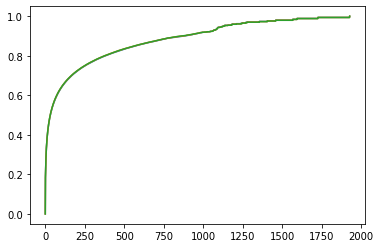

In [32]:
for key in ["KPI1", "KPI1-category", "KPI1-gender"]:
    m = Aw[key].shape[0]
    plt.plot(list(range(m)), [Aw[key][i][0] for i in range(m)])
plt.show()

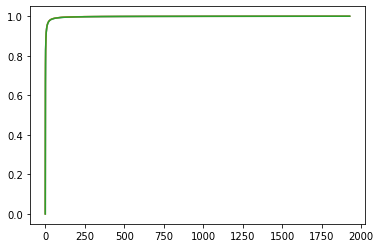

In [33]:
for key in ["KPI2", "KPI2-category", "KPI2-gender"]:
    m = Aw[key].shape[0]
    plt.plot(list(range(m)), [Aw[key][i][0] for i in range(m)])
plt.show()

# Explicit Sampling

In [34]:
np.array(ws['uniform']).flatten()

array([8.108209e-07, 8.108209e-07, 8.108209e-07, ..., 8.108209e-07,
       8.108209e-07, 8.108209e-07], dtype=float32)

In [35]:
print(f"total number of users: {n_users}")
sample_size = 60000
print(f"sample size: {sample_size}")
df_out = pd.DataFrame()
for key in ws.keys():
    S = sorted(np.random.choice(df['user_id'], p=np.array(ws[key].data).flatten(), size=sample_size, replace=False))
    df_out[key] = S

df_out.to_csv('samples.csv')
df_out.head()

total number of users: 1233318
sample size: 60000


,uniform,KPI1-gender-category,KPI2-gender-category,KPI1-gender,KPI2-gender,KPI1-category,KPI2-category,KPI1,KPI2
0,28,7,9,56,11,7,11,57,9
1,51,44,58,75,32,19,32,76,21
2,70,52,79,76,45,55,58,95,31
3,129,111,85,97,49,110,75,111,107
4,152,177,129,103,50,114,114,124,111
